# Intent Classification using Machine Learning

## Dataset Used: [CLINC150][1]
[1]: https://github.com/clinc/oos-eval "CLINC 150"

## Methods Used: SVC, Naive Bayes, MLP

* This notebook contains a step-by-step implementation of Intent classifier systems commonly used in ChatBots. The aim is to classify given query/sentence into a pre-defined unique intent class.

* CLINC-150 dataset contains 10 real-world problem domains having 150 distinct intent classes(with 15 classes in each domain), each with 100 train, 20 validation, 30 test samples.

* For this implementation, I have selected 2 distinct intents from each of the 10 domains resulting in **20** distinct intent-classes (The selection is explained in further sections).

* The raw data is cleaned and tokenized for feature extraction with the help of NLTK's libraries.

* Features selection is one of the important aspect that was decided based on the dataset, nature of queries and classifier model to be implemented. For simplicity purpose, the features used here are in the category of "Bag-of-Words". Other feature extractors and encodings such as N-Gram, GLoVe, USE can improve the performance based on the classifier model.

* The performance is evaluated based on standard classification metrics such as Precision, Recall, F1-Score, and Accuracy. Here along with precision, recall is also important and thus F1 score along with accuracy will be the sufficient metrics for evaluation.

###  Imports

In [1]:
# Data Loading
import json
import pandas as pd

In [2]:
# Data Cleaning and preprocessing
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [3]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Data Loading

* **Assumption**: Data_full.json is stored in the same directory as of this notebook.

* JSON structure:

    {
        "train": List of training samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
        "val":  List of validation samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
         "test":  List of testing samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
          ...further similar 3 sets for out-of-scope queries for advance classification.
    }

In [5]:
# Read data from JSON file
with open('data_full.json') as json_file: 
    data_dict = json.load(json_file) 

In [6]:
# Load data into respective dicts
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['test']

In [7]:
# Converting to Dataframe for sorting/filtering
train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

### Filter Domains and intents

* By observation, Selected 2 intents from each domain as follows:

    1. **Banking**          : "balance", "pin_change"

    2. **Credit Cards**     : "credit_score", "rewards_balance"

    3. **Kitchen & Dining** : "calories", "restaurant_reviews"

    4. **Home**             : "shopping_list", "next_song" 

    5. **Auto & Commute**   : "traffic", "uber"

    6. **Travel**           : "translate", "vaccines"

    7. **Utility**          : "alarm", "date"

    8. **Work**             : "taxes", "insurance"

    9. **Small Talk**       : "greeting", "fun_fact"

    10. **Meta**            : "cancel", "yes"


* Selected 20 intents:  "balance", "pin_change","credit_score", "rewards_balance","calories", 
                        "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                        "translate", "vaccines","alarm", "date", "taxes", 
                        "insurance", "greeting", "fun_fact","cancel", "yes"

In [8]:
# Selected 20 output intents
intent_small = ["balance", "pin_change","credit_score", "rewards_balance","calories",
                "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                "translate", "vaccines","alarm", "date", "taxes", 
                "insurance", "greeting", "fun_fact","cancel", "yes"]

In [9]:
# Filter dataframes with selected 20 intents
train_df_small = train_df[train_df['intent'].isin(intent_small)]
val_df_small = val_df[val_df['intent'].isin(intent_small)]
test_df_small = test_df[test_df['intent'].isin(intent_small)]
print("Total Samples-: Train: {0}, Validation: {1}, Test: {2}".format(len(train_df_small),len(val_df_small),len(test_df_small)))

# Append all sets together for ease of vectorization in further steps. Although, individual dataframes can be used as well.
entire_small_df = train_df_small.append(val_df_small).append(test_df_small)
print("Total Samples combined: ",len(entire_small_df))

Total Samples-: Train: 2000, Validation: 400, Test: 600
Total Samples combined:  3000


In [10]:
# train_sents = list(train_df_small["query"])
# val_sents = list(val_df_small["query"])
# test_sents = list(test_df_small["query"])

In [11]:
# Get sentences into list
entire_sents = list(entire_small_df["query"])
entire_intents = list(entire_small_df["intent"])

In [12]:
# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.
entire_small_df['category_id'] = entire_small_df['intent'].factorize()[0]
category_id_df = entire_small_df[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'intent']].values)
labels = entire_small_df.category_id

### Data Cleaning

1. Replace non-alphanumeric characters from text, such as punctuations, hyphens, symbols, etc. 
2. Tokenize the sentences into chunks of words, i.e. tokens, using NLTK's word_tokenize 
3. Lemmatize the tokens i.e. convert the tokens to its dictionary form using WordNetLemmatizer from NLTK.
4. Returns a wordlist for a list of sentences.

In [13]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer()
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)
        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [14]:
# cleaned_train_sents = cleaning(train_sents)
# cleaned_val_sents = cleaning(val_sents)
# cleaned_test_sents = cleaning(test_sents)

In [15]:
cleaned_entire_sents = cleaning(entire_sents)
print(cleaned_entire_sents[10:15])

[['how', 'would', 'i', 'say', 'i', 'don', 't', 'know', 'the', 'answer', 'in', 'spanish'], ['i', 'would', 'like', 'to', 'know', 'the', 'proper', 'way', 'to', 'greet', 'an', 'adult', 'in', 'portuguese'], ['what', 'word', 'would', 'i', 'use', 'to', 'tell', 'someone', 'i', 'am', 'lost', 'if', 'i', 'were', 'japanese'], ['how', 'would', 'i', 'say', 'thank', 'you', 'if', 'i', 'were', 'russian'], ['can', 'you', 'tell', 'me', 'how', 'i', 'would', 'normally', 'say', 'thank', 'you', 'a', 'a', 'french', 'person']]


### Feature Selection and Vectorization

* Based on the pattern in the queries, it can be seen that, the most representative features of a class are the keywords used in the queries itself.

* The position and the occurrences of these words in the sentence matters as they contribute to the intent directly.

* To capture this essence, a Bag-of-Words can be created and utilized for information retrieval using TF-IDF. As this is a simpler example, TF-IDF with N-grams will be sufficient in identification of intent features.

* Here TF-IDF is used with unigrams and bigrams and max_features are experimented with various combinations of N-grams.

In [16]:
def temp_tokenizer(text):
    return text

In [17]:
# Feature size is limited to 8000 which is large enough to include all the important N-grams
# A dummy tokenizer is passed to include a list of lists inside the vectorizer
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, tokenizer=temp_tokenizer, ngram_range=(1,2))
X_entire = tfidf.fit_transform(cleaned_entire_sents).toarray()

In [18]:
# Validating N-Grams to see the features representing the intent classes
N = 2 # 3
for classs, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(X_entire, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(classs))
    print("  - Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    #print("  - Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'alarm':
  - Most correlated unigrams:
. set
. alarm
  - Most correlated bigrams:
. alarm for
. an alarm
# 'balance':
  - Most correlated unigrams:
. balance
. bank
  - Most correlated bigrams:
. in my
. my bank
# 'calories':
  - Most correlated unigrams:
. many
. calorie
  - Most correlated bigrams:
. calorie are
. many calorie
# 'cancel':
  - Most correlated unigrams:
. cancel
. stop
  - Most correlated bigrams:
. stop talking
. cancel that
# 'credit_score':
  - Most correlated unigrams:
. score
. credit
  - Most correlated bigrams:
. credit score
. my credit
# 'date':
  - Most correlated unigrams:
. day
. date
  - Most correlated bigrams:
. s date
. the date
# 'fun_fact':
  - Most correlated unigrams:
. fact
. about
  - Most correlated bigrams:
. fun fact
. fact about
# 'greeting':
  - Most correlated unigrams:
. hi
. hey
  - Most correlated bigrams:
. how are
. are you
# 'insurance':
  - Most correlated unigrams:
. benefit
. insurance
  - Most correlated bigrams:
. my insurance
.

### Data Split

There are total 3000 queries: 2000 Training, 400 Validation, 600 Testing.

For these classifiers, cross-validation is not done to keep it simpler and thus validation set is not considered. However, for future models, it can be used, thus kept in the vectorized data.

In [19]:
# First 2000 rows corresponds to training data
X_train = X_entire[:2000]
y_train = entire_intents[:2000]

# Rows 2400 to 3000 corresponds to Testing data
X_test = X_entire[2400:]
y_test = entire_intents[2400:]

# Classifier Model Preparation

Here, I have implemented 4 basic classification models using Scikit Learn.

1. Support Vector Classifier
2. XGBoost Trees Classifier
3. Multinomial Naive Bayes Classifier
4. Multi Layer Perceptron

In [20]:
svclassifier = SVC()
XGBclassifier = XGBClassifier()
nb_classifier = MultinomialNB()
mlp_classifier = MLPClassifier()

clf_dict = {
            "SVClassifier" : svclassifier,
            "XGBClassifier": XGBclassifier,
            "NaiveBayesClassifier": nb_classifier,
            "MultilayerPercpClassifier":mlp_classifier
            }

In [21]:
def fit_classifier(label, clf, X_train, y_train):
    print('======================================================')
    print("Training Classifier : ", label)
    return clf.fit(X_train, y_train)
    

In [22]:
def evaluate_classifier(label, clf, X_test, y_test):
    print('======================================================')
    print("Testing Classifier: ", label)
    
    y_pred = clf.predict(X_test)
    #classification_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average='macro')
    print('\nClassification Metrics:')
    print('Precision : {}'.format(precision))
    print( 'Recall    : {}'.format(recall))
    print('F-score   : {}'.format(fscore))
    print('Accuracy  : {}'.format(accuracy))
    print('======================================================')
    

In [23]:
def train_and_evaluate_clf(clf_dict, X_train, y_train, X_test, y_test):
    
    print("Training and Evaluating all the models:")
    
    for label, clf in clf_dict.items():
        
        trained_classifier = fit_classifier(label, clf, X_train, y_train)
        print('======================================================')
        
        evaluate_classifier(label, trained_classifier, X_test, y_test)
    
    

In [24]:
train_and_evaluate_clf(clf_dict, X_train, y_train, X_test, y_test)

Training and Evaluating all the models:
Training Classifier :  SVClassifier
Testing Classifier:  SVClassifier

Classification Metrics:
Precision : 0.9578781842495608
Recall    : 0.9416666666666664
F-score   : 0.9451050490857338
Accuracy  : 0.9416666666666667
Training Classifier :  XGBClassifier
Testing Classifier:  XGBClassifier

Classification Metrics:
Precision : 0.9500508813591738
Recall    : 0.9383333333333332
F-score   : 0.9391039917665356
Accuracy  : 0.9383333333333334
Training Classifier :  NaiveBayesClassifier
Testing Classifier:  NaiveBayesClassifier

Classification Metrics:
Precision : 0.9560276408135753
Recall    : 0.9549999999999998
F-score   : 0.9538944144303793
Accuracy  : 0.955
Training Classifier :  MultilayerPercpClassifier
Testing Classifier:  MultilayerPercpClassifier

Classification Metrics:
Precision : 0.9680808870352807
Recall    : 0.9650000000000001
F-score   : 0.9646267511672869
Accuracy  : 0.965


In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


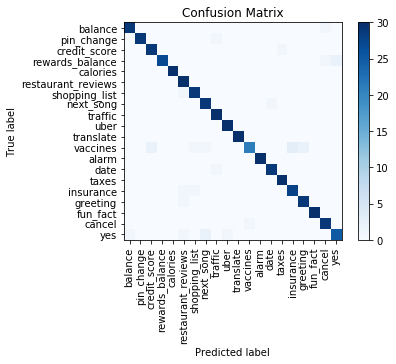

In [26]:
y_pred = nb_classifier.predict(X_test)
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=matrix, normalize=True, classes=intent_small, title='Confusion Matrix')